# Import Libraries

In [ ]:
# Install necessary libraries
!pip install requests pandas beautifulsoup4
!pip install fuzzywuzzy python-Levenshtein
!pip install matplotlib seaborn
!pip install datetime
!pip install random
!pip install time

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import requests
from bs4 import BeautifulSoup
import re
import time
from fuzzywuzzy import fuzz

# Generating the Dataset

In [11]:
# Define sample data for generation
customer_ids = [f"C{str(i).zfill(3)}" for i in range(1, 101)]
product_categories = ['Electronics', 'Clothing', 'Home Appliances', 'Books', 'Beauty', 'Sports', 'Toys']

# Function to generate random timestamp
def random_date(start, end):
    delta = end - start
    random_days = random.randint(0, delta.days)
    random_seconds = random.randint(0, 86399)  # Seconds in a day
    return start + timedelta(days=random_days, seconds=random_seconds)

# Generate synthetic dataset
num_records = 1000
data = {
    'Customer_ID': np.random.choice(customer_ids, num_records),
    'Product_Category': np.random.choice(product_categories, num_records),
    'Purchase_Amount': np.round(np.random.uniform(10.0, 1000.0, num_records), 2),
    'Timestamp': [random_date(datetime(2023, 1, 1), datetime(2024, 12, 31)) for _ in range(num_records)]
}

# Create DataFrame
purchase_data = pd.DataFrame(data)

# Save dataset to CSV
csv_file_path = 'purchase_data.csv'
purchase_data.to_csv(csv_file_path, index=False)

# Display first few rows
purchase_data.head()


,Customer_ID,Product_Category,Purchase_Amount,Timestamp
0,C072,Sports,639.67,2024-09-25 14:22:36
1,C015,Electronics,554.14,2023-11-03 14:13:02
2,C049,Beauty,185.56,2023-03-21 19:23:18
3,C094,Beauty,721.58,2024-04-09 13:47:33
4,C095,Sports,415.91,2024-09-18 10:44:00


# 1. Data Loading and Preprocessing

In [12]:
# Load the dataset into a Pandas DataFrame
def load_data(file_path):
    try:
        df = pd.read_csv(file_path)
        print("Data loaded successfully.")
        return df
    except FileNotFoundError:
        print("File not found. Please check the file path.")
        return None

# Handle missing data
def handle_missing_data(df):
    # Check for missing values
    print("Missing values before handling:")
    print(df.isnull().sum())

    # Fill missing numerical values with the median
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

    # Fill missing categorical values with the mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

    print("Missing values after handling:")
    print(df.isnull().sum())
    return df

# Convert date columns to datetime format
def convert_date_columns(df, date_col):
    try:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        print(f"Converted {date_col} to datetime format.")
    except KeyError:
        print(f"Column {date_col} not found.")
    return df

# Ensure numerical columns are correctly formatted
def format_numeric_columns(df, numeric_cols):
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    print("Formatted numerical columns.")
    return df

# Remove duplicates
def remove_duplicates(df):
    initial_count = len(df)
    df = df.drop_duplicates()
    print(f"Removed {initial_count - len(df)} duplicate rows.")
    return df

# Standardize column names
def standardize_column_names(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    print("Standardized column names.")
    return df

# Filter out invalid data
def filter_invalid_data(df, col, min_val=None, max_val=None):
    if min_val is not None:
        df = df[df[col] >= min_val]
    if max_val is not None:
        df = df[df[col] <= max_val]
    print(f"Filtered {col} with range ({min_val}, {max_val}).")
    return df

# Detect and remove outliers using the IQR method
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    initial_count = len(df)
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    print(f"Removed outliers from {col}. Rows removed: {initial_count - len(df)}")
    return df

# Main function to execute preprocessing
if __name__ == "__main__":
    file_path = "purchase_data.csv"
    date_col = "Timestamp"
    numeric_cols = ["Purchase_Amount"]

    # Load the data
    df = load_data(file_path)

    if df is not None:
        # Preprocess the data
        df = handle_missing_data(df)
        df = convert_date_columns(df, date_col)
        df = format_numeric_columns(df, numeric_cols)
        df = remove_duplicates(df)
        df = standardize_column_names(df)
        df = filter_invalid_data(df, "purchase_amount", min_val=0)
        df = remove_outliers(df, "purchase_amount")

        # Display the first few rows of the cleaned dataset
        print("Data after preprocessing:")
        print(df.head())


Data loaded successfully.
Missing values before handling:
Customer_ID         0
Product_Category    0
Purchase_Amount     0
Timestamp           0
dtype: int64
Missing values after handling:
Customer_ID         0
Product_Category    0
Purchase_Amount     0
Timestamp           0
dtype: int64
Converted Timestamp to datetime format.
Formatted numerical columns.
Removed 0 duplicate rows.
Standardized column names.
Filtered purchase_amount with range (0, None).
Removed outliers from purchase_amount. Rows removed: 0
Data after preprocessing:
  customer_id product_category  purchase_amount           timestamp
0        C072           Sports           639.67 2024-09-25 14:22:36
1        C015      Electronics           554.14 2023-11-03 14:13:02
2        C049           Beauty           185.56 2023-03-21 19:23:18
3        C094           Beauty           721.58 2024-04-09 13:47:33
4        C095           Sports           415.91 2024-09-18 10:44:00


# 2. Exploratory Data Analysis

Summary Statistics:
        customer_id product_category  purchase_amount  \
count         1000             1000      1000.000000   
unique         100                7              NaN   
top           C059            Books              NaN   
freq            20              152              NaN   
mean           NaN              NaN       513.103940   
min            NaN              NaN        11.810000   
25%            NaN              NaN       264.642500   
50%            NaN              NaN       522.420000   
75%            NaN              NaN       755.962500   
max            NaN              NaN       999.640000   
std            NaN              NaN       284.137112   

                            timestamp  
count                            1000  
unique                            NaN  
top                               NaN  
freq                              NaN  
mean    2023-12-28 02:02:23.281000192  
min               2023-01-01 02:51:21  
25%               2023-06-

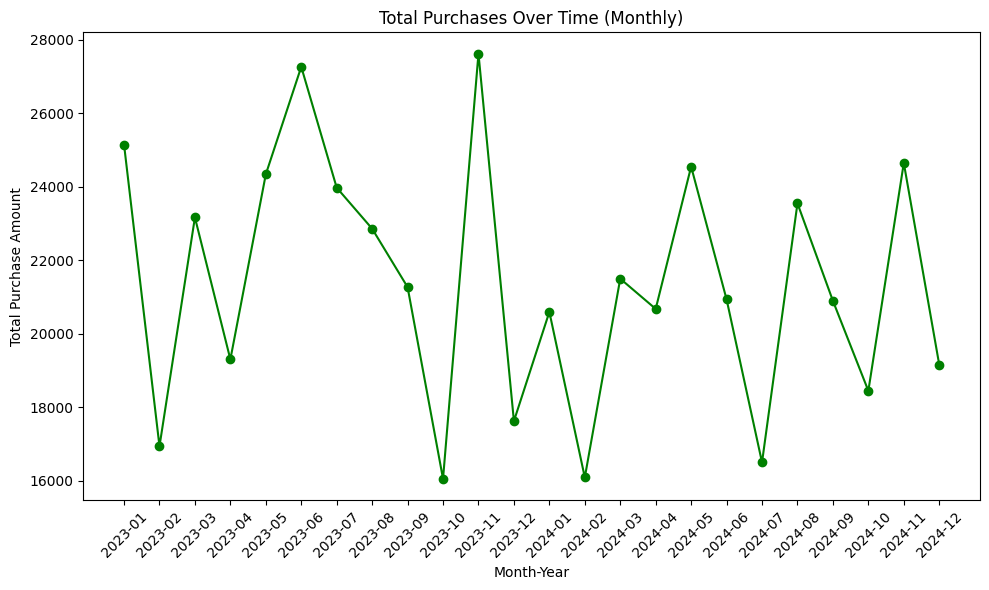

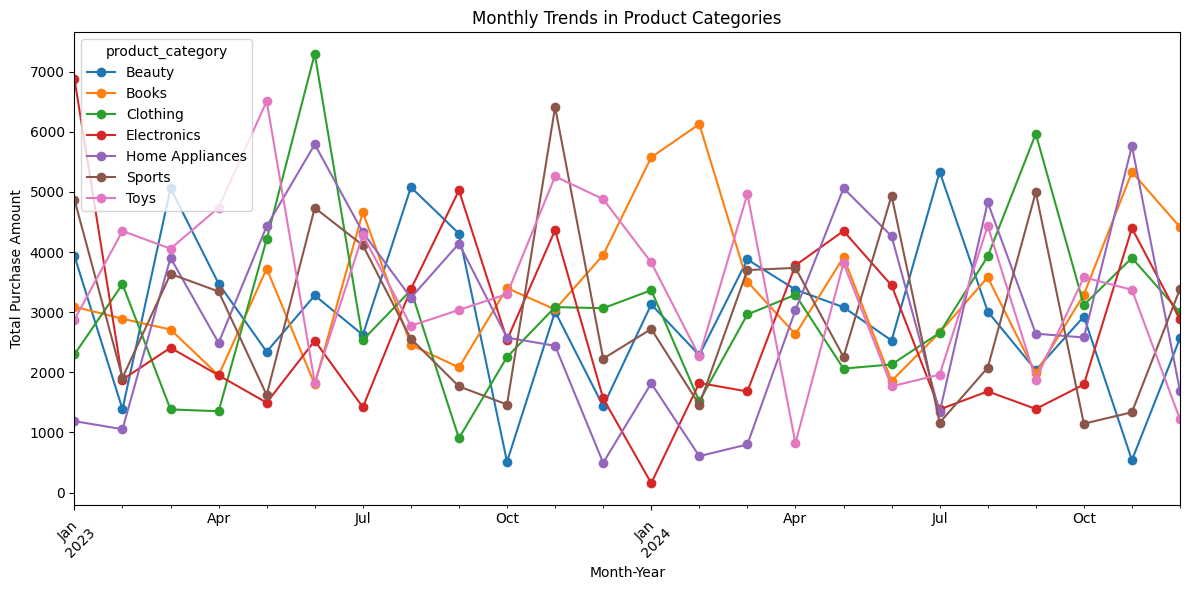


Correlation Matrix:
                  purchase_amount
purchase_amount              1.0

Customer Spending Difference Between First and Last Purchase:
   customer_id  spending_diff
0        C001        -568.54
1        C002        -763.86
2        C003         483.64
3        C004         106.60
4        C005        -208.60


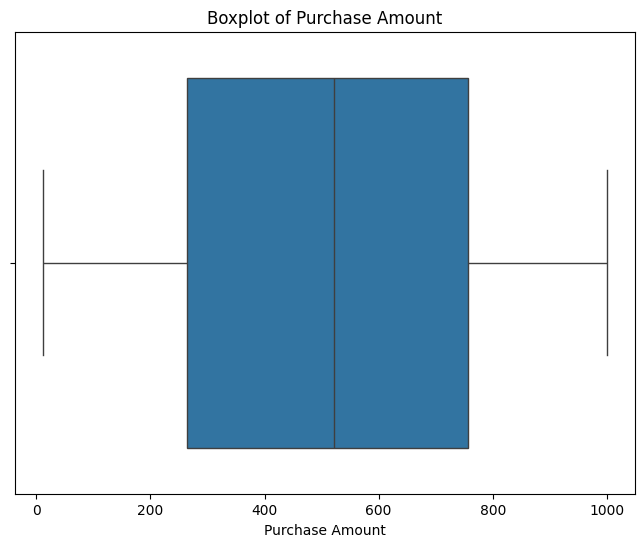

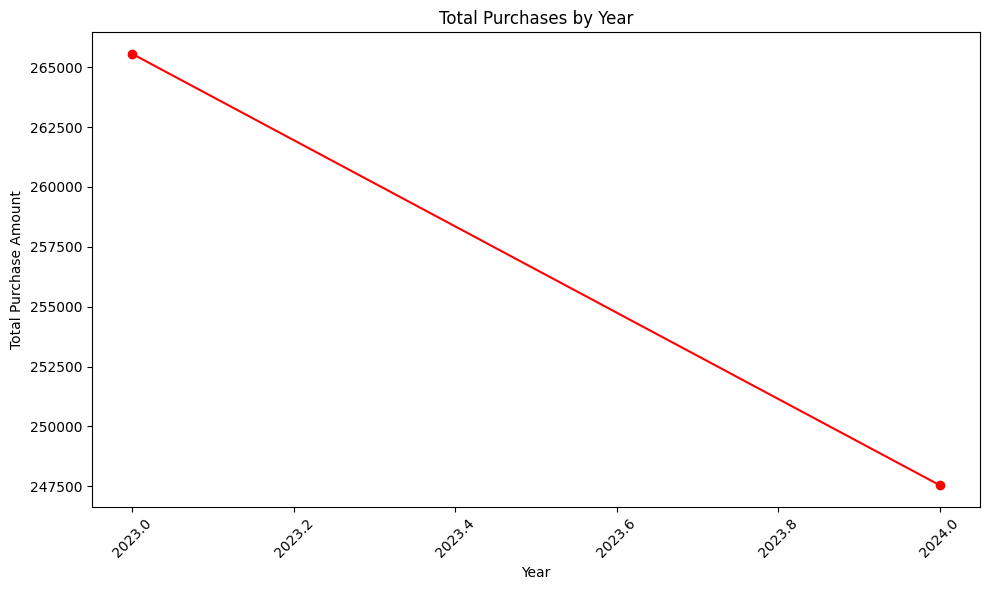

In [13]:
# 1. Summary Statistics
summary_stats = df.describe(include='all')  # Include all columns for a comprehensive summary
mean_purchase = df['purchase_amount'].mean()  # Mean of purchase amounts
median_purchase = df['purchase_amount'].median()  # Median of purchase amounts
mode_purchase = df['purchase_amount'].mode()[0]  # Mode of purchase amounts

# 2. Total Purchases Over Time
df['date'] = df['timestamp'].dt.date  # Extract date from timestamp
daily_purchases = df.groupby('date')['purchase_amount'].sum().reset_index()

# 3. Most Popular Product Categories
popular_categories = df['product_category'].value_counts().reset_index()
popular_categories.columns = ['product_category', 'count']

# 4. Average Spending Per Customer
avg_spending_per_customer = df.groupby('customer_id')['purchase_amount'].mean().reset_index()
avg_spending_per_customer.columns = ['customer_id', 'average_spending']

# 5. Most Active Customer (based on number of purchases)
customer_activity = df['customer_id'].value_counts().reset_index()
customer_activity.columns = ['customer_id', 'purchase_count']
most_active_customer = customer_activity.iloc[0]

# Print insights
print("Summary Statistics:\n", summary_stats)
print("\nMean Purchase Amount:", mean_purchase)
print("Median Purchase Amount:", median_purchase)
print("Mode Purchase Amount:", mode_purchase)
print("\nDaily Purchases:\n", daily_purchases)
print("\nMost Popular Product Categories:\n", popular_categories)
print("\nAverage Spending Per Customer:\n", avg_spending_per_customer)
print("\nMost Active Customer:\n", most_active_customer)

# 6. Customer Segmentation: Segment customers based on total spending
total_spending_per_customer = df.groupby('customer_id')['purchase_amount'].sum().reset_index()
total_spending_per_customer.columns = ['customer_id', 'total_spending']

# Define segments based on spending
bins = [0, 200, 500, 1000, float('inf')]  # Define bins for segments
labels = ['Low', 'Medium', 'High', 'Very High']
total_spending_per_customer['spending_segment'] = pd.cut(total_spending_per_customer['total_spending'], bins=bins, labels=labels)

# Summary of spending segments
spending_segment_summary = total_spending_per_customer['spending_segment'].value_counts().reset_index()
spending_segment_summary.columns = ['spending_segment', 'customer_count']
print("\nSpending Segment Summary:\n", spending_segment_summary)

# 7. Purchase Frequency: Time difference between purchases
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by=['customer_id', 'timestamp'])

# Calculate time difference between purchases
df['purchase_diff'] = df.groupby('customer_id')['timestamp'].diff().dt.days

# Summary of purchase frequency
purchase_frequency_summary = df['purchase_diff'].describe()  # Statistical summary of purchase intervals
print("\nPurchase Frequency Summary:\n", purchase_frequency_summary)

# 8. Trends Over Time: Monthly Purchase Trends
df['month_year'] = df['timestamp'].dt.to_period('M')
monthly_trends = df.groupby('month_year')['purchase_amount'].sum().reset_index()

# Plot monthly trends in purchase amount
plt.figure(figsize=(10, 6))
plt.plot(monthly_trends['month_year'].astype(str), monthly_trends['purchase_amount'], marker='o', color='g')
plt.title('Total Purchases Over Time (Monthly)')
plt.xlabel('Month-Year')
plt.ylabel('Total Purchase Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Category trends over time
category_monthly_trends = df.groupby(['month_year', 'product_category'])['purchase_amount'].sum().reset_index()
category_monthly_trends_pivot = category_monthly_trends.pivot(index='month_year', columns='product_category', values='purchase_amount')

# Plot category trends over time
category_monthly_trends_pivot.plot(figsize=(12, 6), marker='o', title="Monthly Trends in Product Categories")
plt.xlabel('Month-Year')
plt.ylabel('Total Purchase Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 9. Correlation Analysis: Correlation between numerical columns
correlation_matrix = df[['purchase_amount']].corr()
print("\nCorrelation Matrix:\n", correlation_matrix)

# 10. Customer Behavior (First vs. Last Purchase)
first_purchase = df.groupby('customer_id')['timestamp'].min().reset_index()
last_purchase = df.groupby('customer_id')['timestamp'].max().reset_index()

# Merge data to analyze purchase amount differences
customer_first_last = pd.merge(first_purchase, last_purchase, on='customer_id', suffixes=('_first', '_last'))
customer_first_last = pd.merge(customer_first_last, df[['customer_id', 'timestamp', 'purchase_amount']],
                               left_on=['customer_id', 'timestamp_first'], right_on=['customer_id', 'timestamp'], how='left')
customer_first_last = pd.merge(customer_first_last, df[['customer_id', 'timestamp', 'purchase_amount']],
                               left_on=['customer_id', 'timestamp_last'], right_on=['customer_id', 'timestamp'], how='left')

# Calculate difference in spending between first and last purchase
customer_first_last['spending_diff'] = customer_first_last['purchase_amount_y'] - customer_first_last['purchase_amount_x']
print("\nCustomer Spending Difference Between First and Last Purchase:\n", customer_first_last[['customer_id', 'spending_diff']].head())

# 11. Outlier Analysis: Visualize outliers in purchase amounts
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['purchase_amount'])
plt.title('Boxplot of Purchase Amount')
plt.xlabel('Purchase Amount')
plt.show()

# 12. Yearly Trends: Total purchases by year
df['year'] = df['timestamp'].dt.year
yearly_trends = df.groupby('year')['purchase_amount'].sum().reset_index()

# Plot yearly purchase trends
plt.figure(figsize=(10, 6))
plt.plot(yearly_trends['year'], yearly_trends['purchase_amount'], marker='o', color='r')
plt.title('Total Purchases by Year')
plt.xlabel('Year')
plt.ylabel('Total Purchase Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 3. Data Visualization

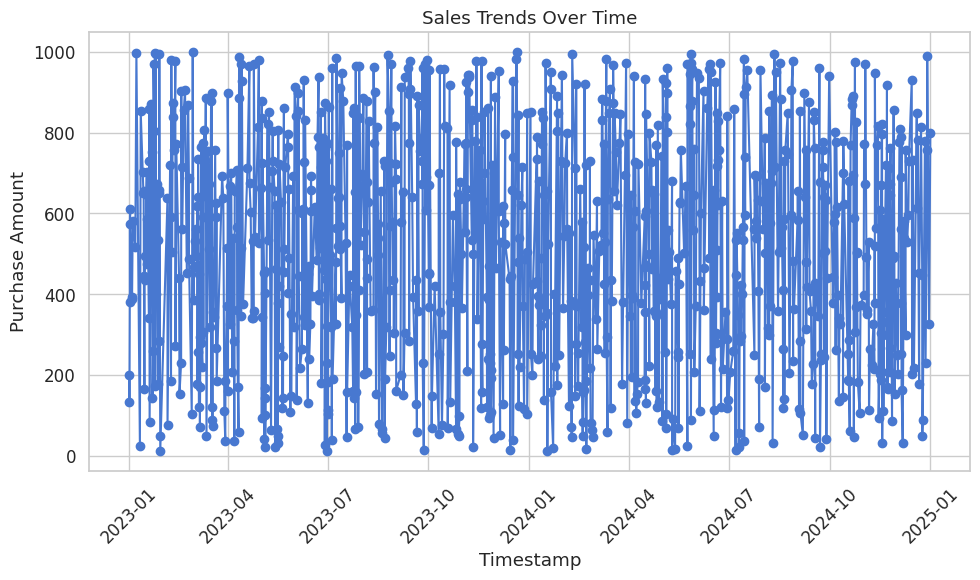

<ipython-input-14-ee987e07351c>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_totals.index, y=category_totals.values, palette='viridis')


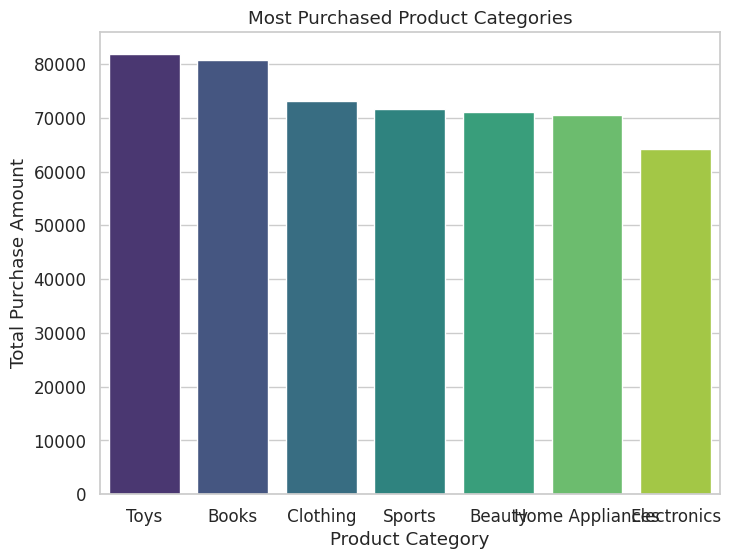

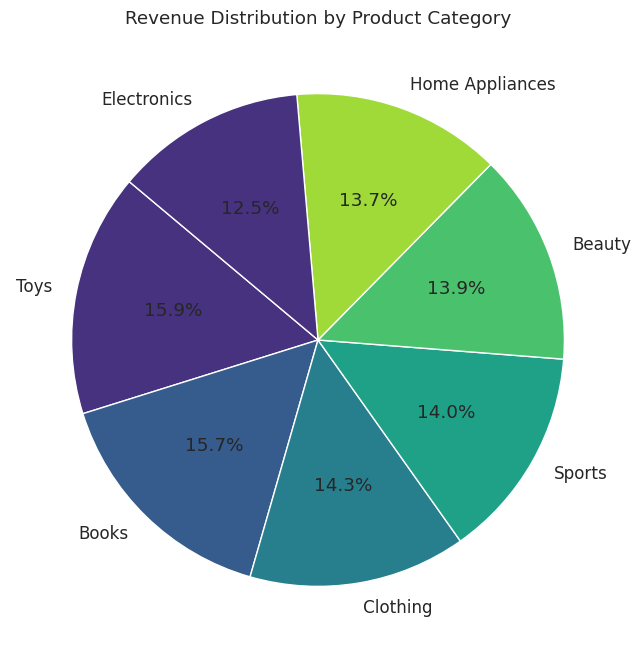

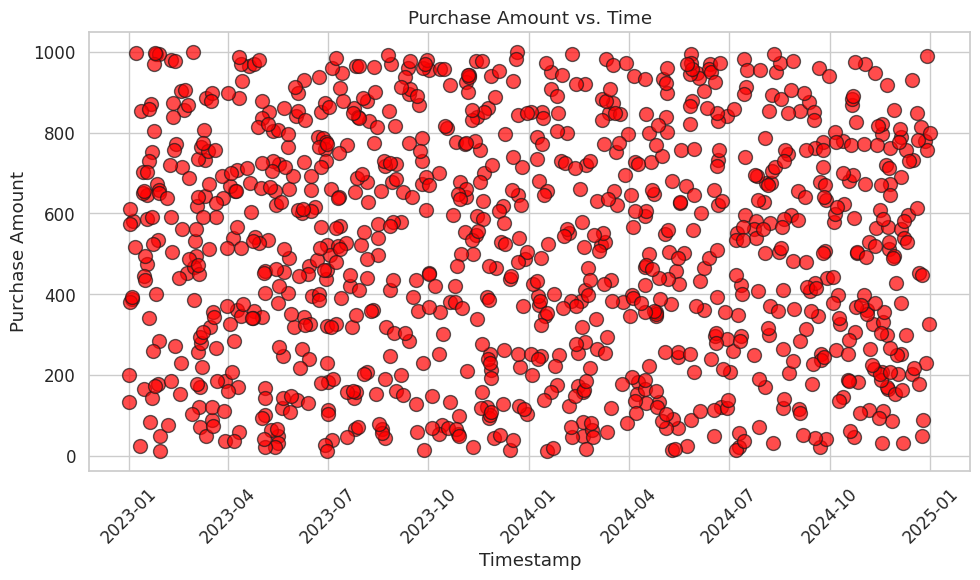

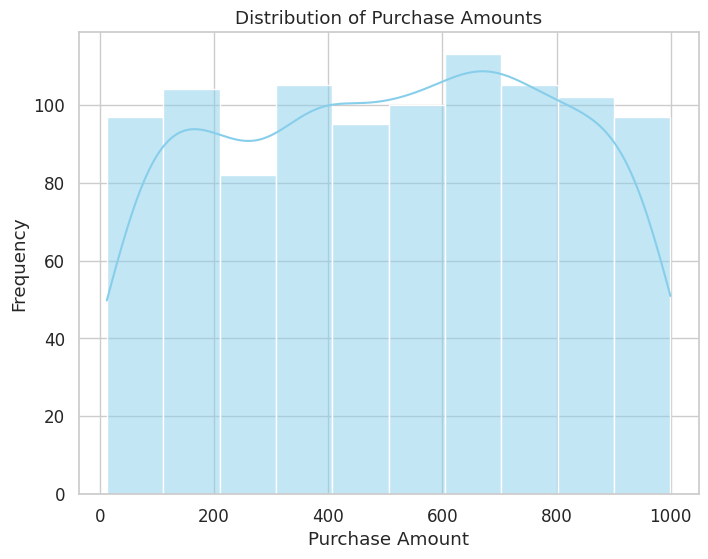

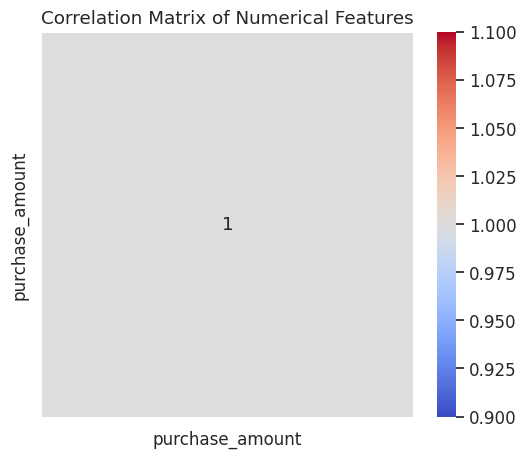

<ipython-input-14-ee987e07351c>:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='product_category', y='purchase_amount', data=df, palette='pastel')


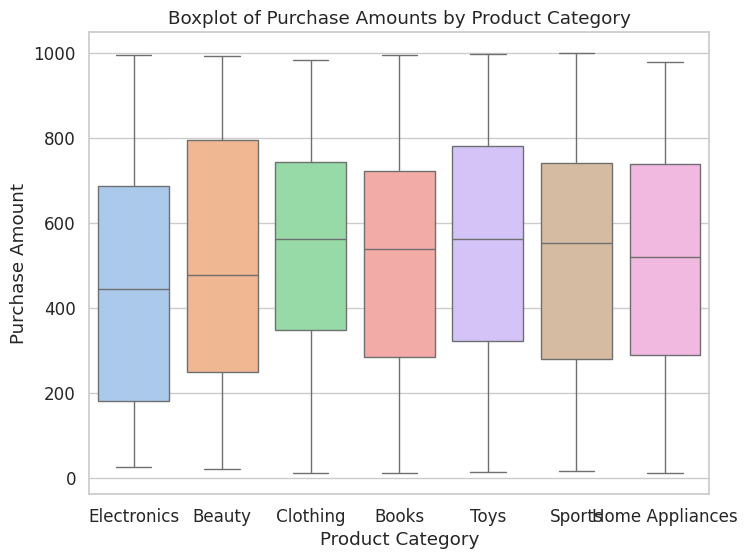

<ipython-input-14-ee987e07351c>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='product_category', y='purchase_amount', data=df, palette='muted')


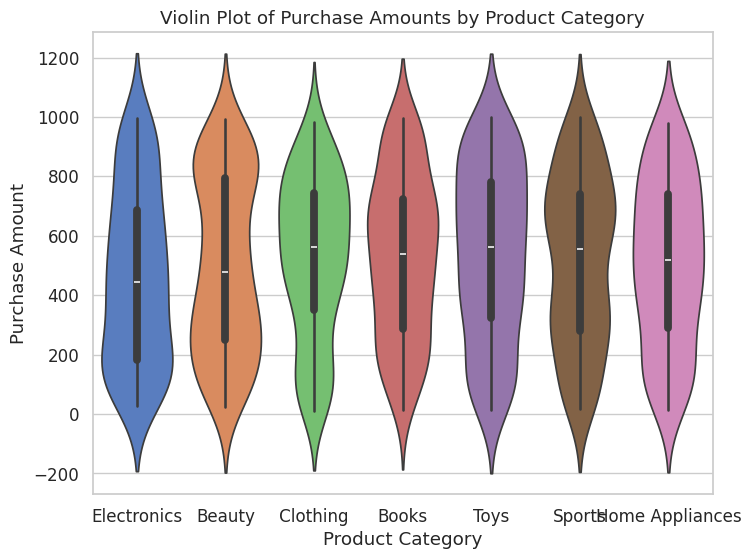

<ipython-input-14-ee987e07351c>:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='product_category', data=df, palette='Set2')


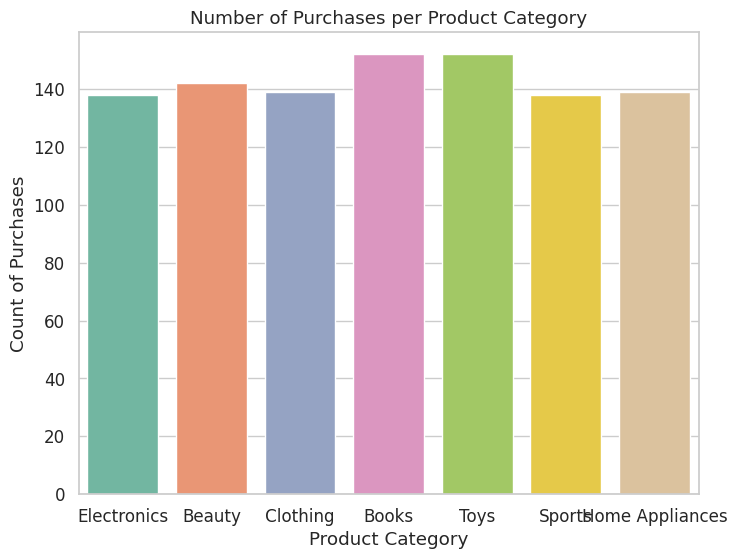

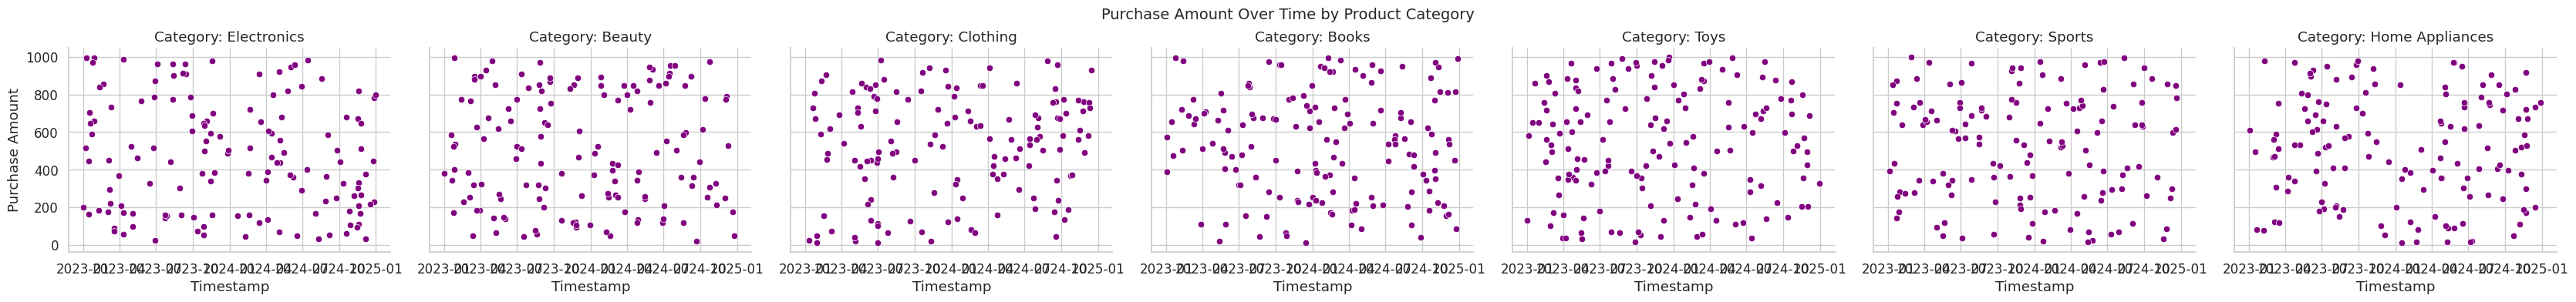

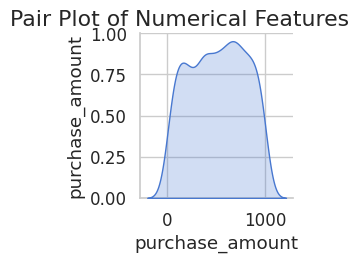

In [14]:
# Set the Seaborn theme for better aesthetics
sns.set(style='whitegrid', palette='muted', font_scale=1.1)

# ---- 1. Line Chart: Sales trends over time ----
plt.figure(figsize=(10, 6))
df_sorted = df.sort_values(by='timestamp')  # Sort by time for accurate trends
plt.plot(df_sorted['timestamp'], df_sorted['purchase_amount'], marker='o', linestyle='-', color='b')
plt.title('Sales Trends Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Purchase Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---- 2. Bar Chart: Most purchased product categories ----
plt.figure(figsize=(8, 6))
category_totals = df.groupby('product_category')['purchase_amount'].sum().sort_values(ascending=False)
sns.barplot(x=category_totals.index, y=category_totals.values, palette='viridis')
plt.title('Most Purchased Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Total Purchase Amount')
plt.show()

# ---- 3. Pie Chart: Percentage of revenue from different product categories ----
plt.figure(figsize=(8, 8))
plt.pie(category_totals, labels=category_totals.index, autopct='%1.1f%%', startangle=140,
        colors=sns.color_palette('viridis'))
plt.title('Revenue Distribution by Product Category')
plt.show()

# ---- 4. Scatter Plot: Relationship between purchase amount and time ----
plt.figure(figsize=(10, 6))
plt.scatter(df['timestamp'], df['purchase_amount'], color='red', s=100, alpha=0.7, edgecolor='k')
plt.title('Purchase Amount vs. Time')
plt.xlabel('Timestamp')
plt.ylabel('Purchase Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---- 5. Histogram: Distribution of purchase amounts ----
plt.figure(figsize=(8, 6))
sns.histplot(df['purchase_amount'], bins=10, kde=True, color='skyblue')
plt.title('Distribution of Purchase Amounts')
plt.xlabel('Purchase Amount')
plt.ylabel('Frequency')
plt.show()

# ---- 6. Heatmap: Correlation between numerical features ----
plt.figure(figsize=(6, 5))
sns.heatmap(df[['purchase_amount']].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# ---- 7. Boxplot: Purchase amounts by product category ----
plt.figure(figsize=(8, 6))
sns.boxplot(x='product_category', y='purchase_amount', data=df, palette='pastel')
plt.title('Boxplot of Purchase Amounts by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Purchase Amount')
plt.show()

# ---- 8. Violin Plot: Purchase amounts by product category ----
plt.figure(figsize=(8, 6))
sns.violinplot(x='product_category', y='purchase_amount', data=df, palette='muted')
plt.title('Violin Plot of Purchase Amounts by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Purchase Amount')
plt.show()

# ---- 9. Count Plot: Number of purchases per product category ----
plt.figure(figsize=(8, 6))
sns.countplot(x='product_category', data=df, palette='Set2')
plt.title('Number of Purchases per Product Category')
plt.xlabel('Product Category')
plt.ylabel('Count of Purchases')
plt.show()

# ---- 10. FacetGrid Scatter Plot: Purchase amount over time by product category ----
g = sns.FacetGrid(df, col="product_category", height=4, aspect=1.2)
g.map_dataframe(sns.scatterplot, x="timestamp", y="purchase_amount", color='purple')
g.set_titles("Category: {col_name}")
g.set_axis_labels("Timestamp", "Purchase Amount")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Purchase Amount Over Time by Product Category', fontsize=14)
plt.show()

# ---- 11. Pair Plot: Relationships between numerical features ----
sns.pairplot(df[['purchase_amount']], diag_kind='kde')
plt.suptitle('Pair Plot of Numerical Features', y=1.02)
plt.show()


# 4. Web Scraping Component

Scraping products for category: Electronics
Successfully fetched page 1 for query 'Electronics'.
Scraped page 1 for query 'Electronics'.
Successfully fetched page 2 for query 'Electronics'.
Scraped page 2 for query 'Electronics'.
Successfully fetched page 3 for query 'Electronics'.
Scraped page 3 for query 'Electronics'.
Scraping products for category: Beauty
Successfully fetched page 1 for query 'Beauty'.
Scraped page 1 for query 'Beauty'.
Successfully fetched page 2 for query 'Beauty'.
Scraped page 2 for query 'Beauty'.
Successfully fetched page 3 for query 'Beauty'.
Scraped page 3 for query 'Beauty'.
Scraping products for category: Clothing
Successfully fetched page 1 for query 'Clothing'.
Scraped page 1 for query 'Clothing'.
Successfully fetched page 2 for query 'Clothing'.
Scraped page 2 for query 'Clothing'.
Successfully fetched page 3 for query 'Clothing'.
Scraped page 3 for query 'Clothing'.
Scraping products for category: Books
Successfully fetched page 1 for query 'Books'.
Sc

<ipython-input-15-49caa68a4506>:102: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  scraped_df['price'].fillna(-1, inplace=True)
<ipython-input-15-49caa68a4506>:103: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

Scraped data saved to 'scraped_amazon_products.csv'.

Price Category Summary:
                average_price  total_purchases
price_category                                
High               799.950000             6000
Low                 27.320364      37860280000
Medium             194.841667        700413000


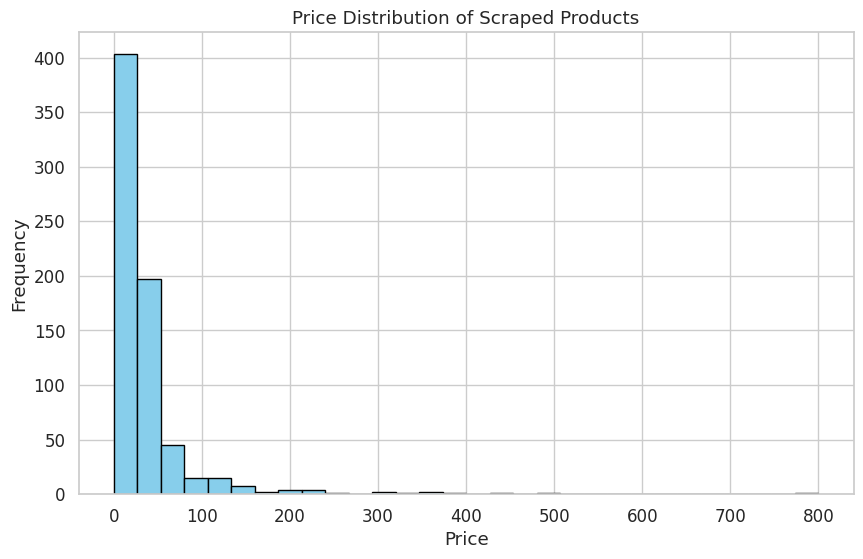

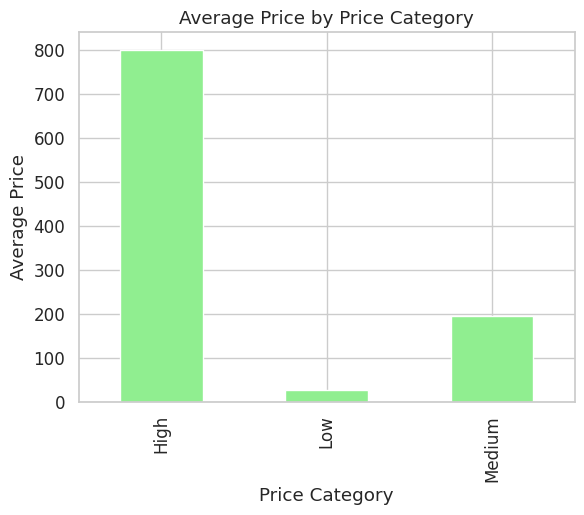


Enhanced Dataset with Price Variation:
    customer_id product_category  purchase_amount           timestamp  \
373        C001      Electronics           995.74 2023-01-07 14:12:40   
97         C001           Beauty           585.25 2023-01-17 06:35:21   
753        C001         Clothing           804.73 2023-01-23 19:59:46   
824        C001           Beauty           772.10 2023-02-12 22:40:59   
661        C001            Books           360.92 2023-08-11 20:45:28   
..          ...              ...              ...                 ...   
474        C100           Sports           863.20 2023-07-02 02:50:24   
489        C100           Beauty            79.45 2023-08-16 21:59:56   
43         C100         Clothing           720.40 2023-11-28 08:59:15   
248        C100  Home Appliances           200.26 2024-01-03 20:14:08   
718        C100  Home Appliances           586.59 2024-11-18 23:02:30   

           date  purchase_diff month_year  year  \
373  2023-01-07            NaN  

In [15]:
# 1. Define scraping function to fetch data from Amazon
def scrape_amazon_products(search_query, max_pages=5):
    """
    Scrapes product details (name, price, last month's purchases, and ratings) from Amazon.
    """
    base_url = "https://www.amazon.com/s?k={query}&page={page}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36",
        "Accept-Language": "en-US,en;q=0.9",
        "Accept-Encoding": "gzip, deflate, br",
        "Connection": "keep-alive",
        "DNT": "1",  # Do Not Track Request Header
        "Upgrade-Insecure-Requests": "1"
    }
    scraped_data = []

    for page in range(1, max_pages + 1):
        url = base_url.format(query=search_query.replace(" ", "+"), page=page)
        response = requests.get(url, headers=headers)

        if response.status_code == 200:
            print(f"Successfully fetched page {page} for query '{search_query}'.")
        else:
            print(f"Status Code: {response.status_code}")
            print(f"Failed to fetch page {page} for query '{search_query}'.")
            continue

        soup = BeautifulSoup(response.content, "html.parser")
        products = soup.find_all("div", {"data-component-type": "s-search-result"})

        for product in products:
            # Extract product title
            title_tag = product.find("h2", {"class": "a-size-base-plus a-spacing-none a-color-base a-text-normal"})
            title = title_tag.find("span").text.strip() if title_tag and title_tag.find("span") else "N/A"

            # Extract product price
            price_tag = product.find("span", {"class": "a-offscreen"})
            price = price_tag.text.strip().replace('$', '').replace(',', '') if price_tag else None

            # Extract last month's purchases
            purchases_tag = product.find("span", {"class": "a-size-base a-color-secondary"})
            purchases_text = purchases_tag.text.strip() if purchases_tag else None
            last_month_purchases = parse_purchase_count(purchases_text)

            # Extract product ratings
            rating_tag = product.find("span", {"class": "a-icon-alt"})
            rating_text = rating_tag.text.strip() if rating_tag else None
            # Regular expression to extract the rating before " out of"
            rating = None
            if rating_text:
                match = re.search(r"(\d+(\.\d+)?)\s+out\s+of", rating_text)
                if match:
                    rating = float(match.group(1))  # Extracts the first match (the rating number)
            ratings = rating if rating else "No Rating"

            scraped_data.append({
                "product_name": title,
                "price": price,
                "ratings": ratings,
                "last_month_purchases": last_month_purchases
            })

        print(f"Scraped page {page} for query '{search_query}'.")
        time.sleep(random.uniform(2, 5))

    return scraped_data

def parse_purchase_count(purchase_text):
    """
    Converts purchase count text like '2K+ bought in past month' into an integer.
    """
    if purchase_text and 'bought in past month' in purchase_text:
        # Remove irrelevant parts like "bought in past month" or "+"
        purchase_text = re.sub(r'[^0-9KMkm.]', '', purchase_text)

        multiplier = 1
        if "K" in purchase_text.upper():
            multiplier = 1_000
        elif "M" in purchase_text.upper():
            multiplier = 1_000_000

        # Extract numeric part and multiply
        number = float(re.sub(r'[^\d.]', '', purchase_text))  # Remove all non-numeric characters except digits and "."
        return int(number * multiplier)

    return 0  # Default if no text is found

# 2. Fetch and clean scraped data
categories = df['product_category'].unique()
scraped_results = []

for category in categories:
    print(f"Scraping products for category: {category}")
    results = scrape_amazon_products(category, max_pages=3)
    scraped_results.extend(results)

scraped_df = pd.DataFrame(scraped_results)
scraped_df.dropna(subset=['price'], inplace=True)
scraped_df['price'] = pd.to_numeric(scraped_df['price'], errors='coerce')

# Handle missing data
scraped_df['price'].fillna(-1, inplace=True)
scraped_df['ratings'].fillna("No Rating", inplace=True)
scraped_df['last_month_purchases'].fillna(0, inplace=True)
scraped_df['incomplete_data'] = scraped_df['price'] == -1

# Save the scraped data to a CSV file
scraped_df.to_csv("scraped_amazon_products.csv", index=False)
print("Scraped data saved to 'scraped_amazon_products.csv'.")

# 3. Categorize products based on price
def categorize_price(price):
    if price < 100:
        return "Low"
    elif 100 <= price < 500:
        return "Medium"
    else:
        return "High"

scraped_df['price_category'] = scraped_df['price'].apply(categorize_price)

# 4. Calculate price variation and match products using fuzzy matching
def fuzzy_match_product(row, scraped_data):
    best_match = None
    highest_score = 0
    for scraped_product in scraped_data['product_name']:
        score = fuzz.partial_ratio(row['product_category'], scraped_product)
        if score > highest_score:
            highest_score = score
            best_match = scraped_product
    return best_match

df['matched_product'] = df.apply(lambda x: fuzzy_match_product(x, scraped_df), axis=1)

def calculate_price_variation(row, scraped_data):
    matched_products = scraped_data[scraped_data['product_name'] == row['matched_product']]
    if not matched_products.empty:
        avg_scraped_price = matched_products['price'].mean()
        return row['purchase_amount'] - avg_scraped_price
    return None

df['price_variation'] = df.apply(lambda x: calculate_price_variation(x, scraped_df), axis=1)

# 5. Summarize average price and purchases by category
category_summary = scraped_df.groupby('price_category').agg({
    'price': 'mean',
    'last_month_purchases': 'sum'
}).rename(columns={'price': 'average_price', 'last_month_purchases': 'total_purchases'})

print("\nPrice Category Summary:")
print(category_summary)

# 6. Visualization
plt.figure(figsize=(10, 6))
scraped_df['price'].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
plt.title("Price Distribution of Scraped Products")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

category_summary['average_price'].plot(kind='bar', color='lightgreen')
plt.title("Average Price by Price Category")
plt.xlabel("Price Category")
plt.ylabel("Average Price")
plt.show()

print("\nEnhanced Dataset with Price Variation:")
print(df)


## Visualization after Scrapping

<ipython-input-16-d7ecc7e30196>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='purchase_amount', y='product_category', inner='box', palette='Dark2')


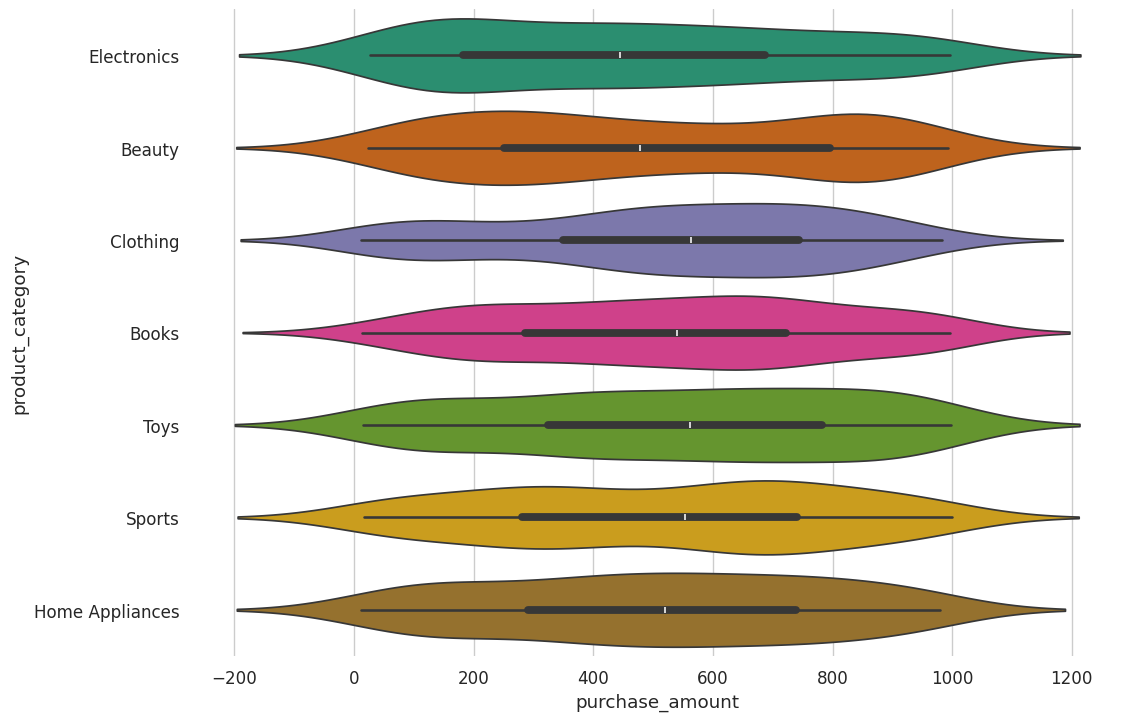

In [16]:
# 13. product_category vs purchase_amount

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['product_category'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='purchase_amount', y='product_category', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

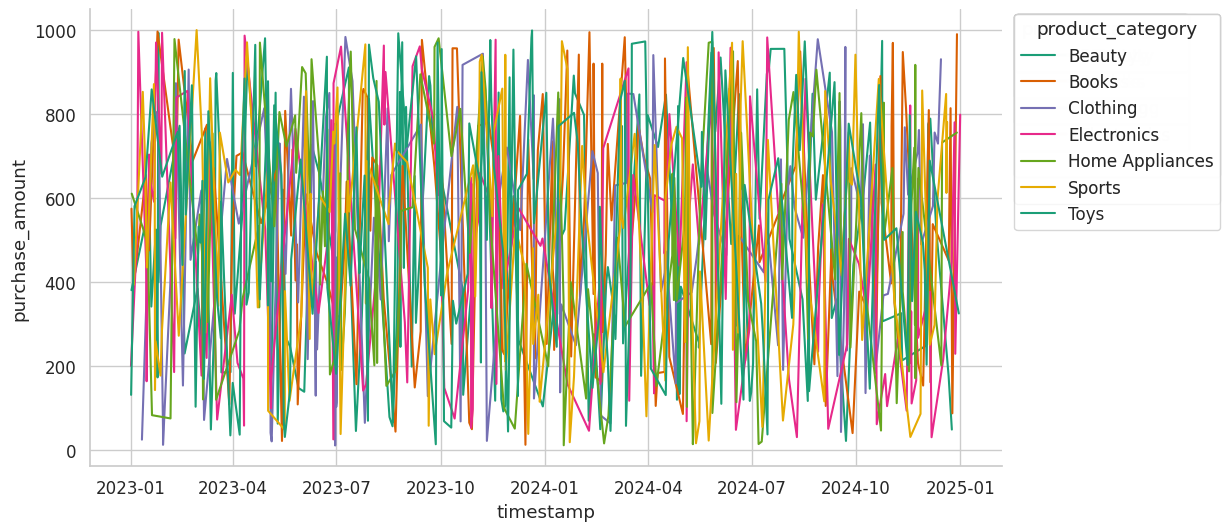

In [17]:
# 12. timestamp vs purchase_amount

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['purchase_amount']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('timestamp', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('product_category')):
  _plot_series(series, series_name, i)
  fig.legend(title='product_category', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('purchase_amount')

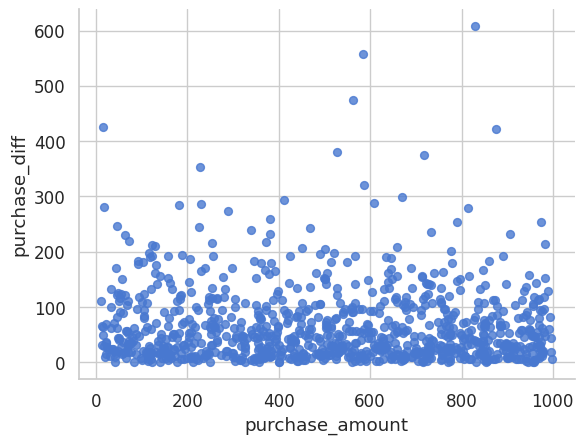

In [18]:
# 11. purchase_amount vs purchase_diff

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='purchase_amount', y='purchase_diff', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

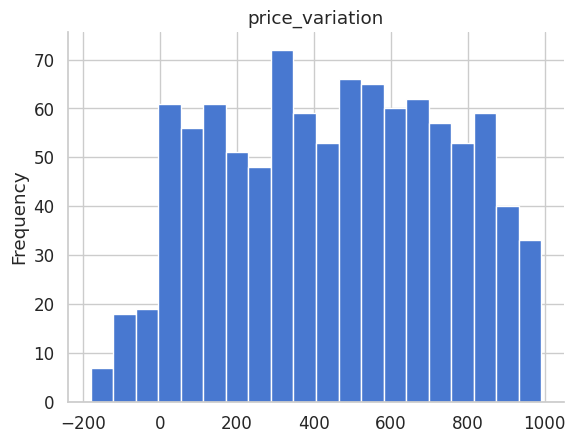

In [19]:
# 10. price_variation

from matplotlib import pyplot as plt
df['price_variation'].plot(kind='hist', bins=20, title='price_variation')
plt.gca().spines[['top', 'right',]].set_visible(False)

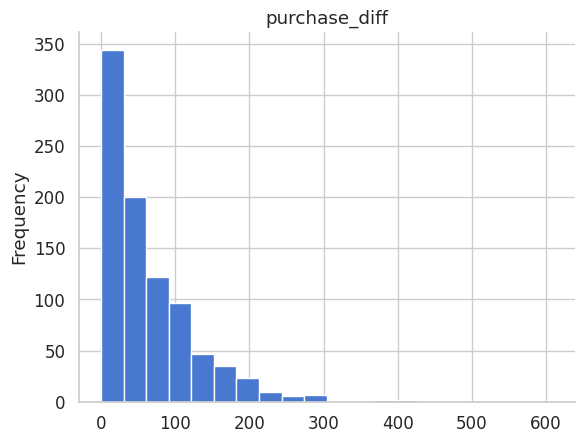

In [20]:
# 9. purchase_diff

from matplotlib import pyplot as plt
df['purchase_diff'].plot(kind='hist', bins=20, title='purchase_diff')
plt.gca().spines[['top', 'right',]].set_visible(False)

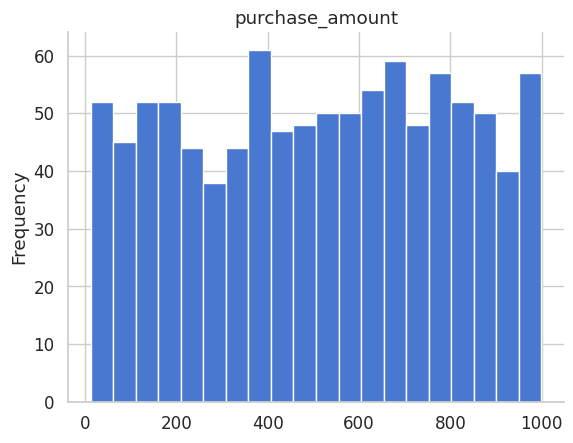

In [21]:
# 8. purchase_amount

from matplotlib import pyplot as plt
df['purchase_amount'].plot(kind='hist', bins=20, title='purchase_amount')
plt.gca().spines[['top', 'right',]].set_visible(False)

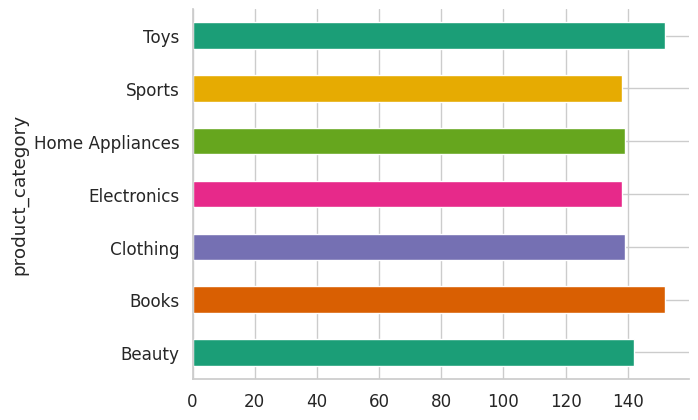

In [22]:
# 7. product_category

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('product_category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Update the Dataframe with new data

In [23]:
# 14. Update purchase_data.csv with new data
def update_purchase_data(new_df, file_path="purchase_data.csv"):
    """
    Replaces the existing data in 'purchase_data.csv' with the newly updated DataFrame.
    """
    try:
        new_df.to_csv(file_path, index=False)
        print(f"Successfully updated {file_path} with new data.")
    except Exception as e:
        print(f"Failed to update {file_path}: {e}")

update_purchase_data(df)

Successfully updated purchase_data.csv with new data.


# 5. Custom Analytics Features

In [24]:
# Function to search purchases by customer ID
def search_purchases_by_customer(customer_id):
    """
    Search for all purchases made by a specific customer.

    Parameters:
        customer_id (str): The ID of the customer to search for.

    Returns:
        DataFrame: A DataFrame containing the purchases of the specified customer.
    """
    try:
        result = df[df['customer_id'] == customer_id]
        return result
    except KeyError as e:
        return f"Error: Missing column {e} in the data."

# Function to filter purchases by date range and minimum purchase amount
def filter_purchases(date_range=None, min_amount=None):
    """
    Filter purchases based on a date range and/or a minimum purchase amount.

    Parameters:
        date_range (tuple): A tuple containing start and end dates (YYYY-MM-DD).
        min_amount (float): The minimum purchase amount to filter by.

    Returns:
        DataFrame: A filtered DataFrame of purchases.
    """
    try:
        filtered_df = df.copy()

        if date_range:
            start_date, end_date = pd.to_datetime(date_range[0]).date(), pd.to_datetime(date_range[1]).date()
            filtered_df = filtered_df[(pd.to_datetime(filtered_df['date']).dt.date >= start_date) &
                                      (pd.to_datetime(filtered_df['date']).dt.date <= end_date)]

        if min_amount:
            filtered_df = filtered_df[filtered_df['purchase_amount'] > min_amount]

        return filtered_df
    except Exception as e:
        return f"Error: {e}"

# Function to calculate total revenue by product category
def calculate_total_revenue_by_category():
    """
    Calculate the total revenue generated by each product category.

    Returns:
        Series: A Series with product categories as the index and total revenue as values.
    """
    try:
        return df.groupby('product_category')['purchase_amount'].sum()
    except KeyError as e:
        return f"Error: Missing column {e} in the data."

# Function to generate a summary report of top-performing products
def summary_report(top_n=3):
    """
    Generate a summary report of the top-performing products based on purchase amount.

    Parameters:
        top_n (int): Number of top-performing products to include in the report.

    Returns:
        DataFrame: A DataFrame containing the top-performing products.
    """
    try:
        top_products = df.nlargest(top_n, 'purchase_amount')
        top_products['price_trend'] = top_products['price_variation'] * 1.05  # Example price trend calculation
        return top_products
    except Exception as e:
        return f"Error: {e}"

# Function to identify repeat customers
def identify_repeat_customers(min_purchases=2):
    """
    Identify repeat customers who made a minimum number of purchases.

    Parameters:
        min_purchases (int): The minimum number of purchases to qualify as a repeat customer.

    Returns:
        Series: A Series of repeat customers and their purchase counts.
    """
    try:
        repeat_customers = df['customer_id'].value_counts()
        return repeat_customers[repeat_customers >= min_purchases]
    except KeyError as e:
        return f"Error: Missing column {e} in the data."

# Function to analyze monthly sales trends
def monthly_sales_trends():
    """
    Analyze sales trends on a monthly basis.

    Returns:
        Series: A Series with month-year as the index and total sales as values.
    """
    try:
        return df.groupby('month_year')['purchase_amount'].sum()
    except KeyError as e:
        return f"Error: Missing column {e} in the data."

# Function to calculate average purchase amount by category
def average_purchase_by_category():
    """
    Calculate the average purchase amount for each product category.

    Returns:
        Series: A Series with product categories as the index and average purchase amounts as values.
    """
    try:
        return df.groupby('product_category')['purchase_amount'].mean()
    except KeyError as e:
        return f"Error: Missing column {e} in the data."

# Function to find products with the highest price variation
def highest_price_variation(top_n=3):
    """
    Identify products with the highest price variation.

    Parameters:
        top_n (int): Number of products to include in the result.

    Returns:
        DataFrame: A DataFrame containing the products with the highest price variation.
    """
    try:
        return df.nlargest(top_n, 'price_variation')
    except KeyError as e:
        return f"Error: Missing column {e} in the data."

# Example usage
if __name__ == "__main__":
    print("Search by customer ID (C001):")
    print(search_purchases_by_customer('C001'))

    print("\nFilter purchases in date range 2023-01-01 to 2023-03-01:")
    print(filter_purchases(date_range=('2023-01-01', '2023-03-01')))

    print("\nFilter purchases above $200:")
    print(filter_purchases(min_amount=200))

    print("\nTotal revenue by product category:")
    print(calculate_total_revenue_by_category())

    print("\nSummary report of top-performing products:")
    print(summary_report())

    print("\nRepeat customers:")
    print(identify_repeat_customers())

    print("\nMonthly sales trends:")
    print(monthly_sales_trends())

    print("\nAverage purchase amount by category:")
    print(average_purchase_by_category())

    print("\nProducts with highest price variation:")
    print(highest_price_variation())


Search by customer ID (C001):
    customer_id product_category  purchase_amount           timestamp  \
373        C001      Electronics           995.74 2023-01-07 14:12:40   
97         C001           Beauty           585.25 2023-01-17 06:35:21   
753        C001         Clothing           804.73 2023-01-23 19:59:46   
824        C001           Beauty           772.10 2023-02-12 22:40:59   
661        C001            Books           360.92 2023-08-11 20:45:28   
572        C001             Toys           976.06 2023-11-13 18:02:43   
903        C001             Toys           619.35 2023-12-08 04:43:45   
60         C001           Beauty           133.68 2024-04-28 10:00:56   
330        C001           Sports           371.03 2024-08-07 16:38:58   
442        C001           Beauty           117.72 2024-08-19 13:01:50   
755        C001         Clothing           762.08 2024-11-25 12:03:57   
876        C001             Toys           427.20 2024-11-30 14:52:02   

           date  pur

# Bonus Challenge

In [25]:
# Export filtered data or summary report to Excel
def export_to_excel(filtered_data, summary_data, file_path="enhanced_report.xlsx"):
    """
    Exports filtered data and summary report into an Excel file with separate sheets.
    Avoids unnecessary columns like 'month_year', and 'year'.
    """
    try:
        # Drop unnecessary columns if they exist in the filtered data
        columns_to_exclude = {'month_year', 'year'}
        filtered_data = filtered_data.drop(columns=columns_to_exclude.intersection(filtered_data.columns), errors='ignore')

        with pd.ExcelWriter(file_path) as writer:
            filtered_data.to_excel(writer, sheet_name="Filtered Data", index=False)
            summary_data.to_excel(writer, sheet_name="Summary Report", index=True)
        print(f"Successfully exported data to {file_path}.")
    except Exception as e:
        print(f"Failed to export data to Excel: {e}")

# Example usage
export_to_excel(scraped_df, category_summary)

Successfully exported data to enhanced_report.xlsx.
